# ICEGRAV Synthetic Application

Apply the single and dual equivalent source (EQS) approaches to the ICEGRAV synthetic created in notebook 04_icegrav_datasets.ipynb.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import pyproj
import pygmt
import eqs_magnetics as eqs
import harmonica as hm
import itertools
import xarray as xr
import synthetics
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import griddata
import matplotlib.colors as mcolors
from pathlib import Path
from IPython.display import Image
from matplotlib.ticker import MaxNLocator, FixedLocator
import warnings

In [2]:
# Suppress some scikit-learn warning that isn't valid
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Load Data

In [3]:
icegrav = pd.read_csv('../data/icegrav.csv', header=0)
icegrav_synthetic = pd.read_csv('../data/icegrav_synthetic.csv', header=0)
icegrav_synthetic_sources = pd.read_csv('../data/icegrav_synthetic_sources.csv', header=0)

icegrav_coords = [icegrav.x, icegrav.y, icegrav.Height_WGS1984]
coordinates = [icegrav_synthetic.x, icegrav_synthetic.y, icegrav_synthetic.u]
source_coordinates = [icegrav_synthetic_sources.x, icegrav_synthetic_sources.y, icegrav_synthetic_sources.u]
dipole_moments = [icegrav_synthetic_sources.dipole_moment_x, icegrav_synthetic_sources.dipole_moment_y, icegrav_synthetic_sources.dipole_moment_u]

field_direction = np.array([hm.magnetic_angles_to_vec(1, -65, 30)]).T

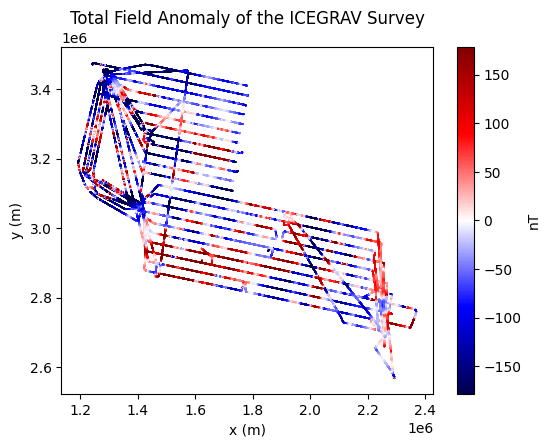

In [4]:
plt.figure(figsize=(6,4.5))
scale_tfa_real = np.nanpercentile(icegrav.MagL, 95)
plt.scatter(*icegrav_coords[:2], c=icegrav.MagL, cmap="seismic",s=0.01, vmin=-scale_tfa_real, vmax=scale_tfa_real)
plt.title("Total Field Anomaly of the ICEGRAV Survey")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.colorbar(label="nT")
plt.show()

In [5]:
grid_spacing = 5e3
region = vd.get_region(coordinates)
grid_coordinates = vd.grid_coordinates(region, spacing=grid_spacing, extra_coords=3e3)
mask = vd.distance_mask(data_coordinates=coordinates, maxdist=28e3, coordinates=grid_coordinates)
grid_coords_masked = (
    np.array((xr.DataArray(grid_coordinates[0])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[1])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[2])).where(mask, drop=False))
)
true_b = eqs.dipole_magnetic(grid_coords_masked, source_coordinates, dipole_moments)
true_tfa = eqs.total_field_anomaly(true_b, field_direction)
true_bnorm = np.sqrt(sum(c**2 for c in true_b))

In [6]:
coordinates_km = [coord / 1000 for coord in coordinates]
grid_coordinates_km = [coord / 1000 for coord in grid_coordinates]
grid_coords_masked_km = [coord / 1000 for coord in grid_coords_masked]

In [7]:
# Define a custom colormap similar to the red portion of the seismic colour scheme for the norm of b figures.
colours = [(1, 1, 1), (1, 0.3, 0.3), (1, 0, 0), (0.5, 0, 0)]  # White -> bright light red -> bright red -> dark red
n_bins = 100  
red_cm = mcolors.LinearSegmentedColormap.from_list("white_to_red", colours, N=n_bins)
red_norm = mcolors.Normalize(vmin=0, vmax=vd.maxabs(icegrav_synthetic.bnorm)) # Normalise with the bnorm range

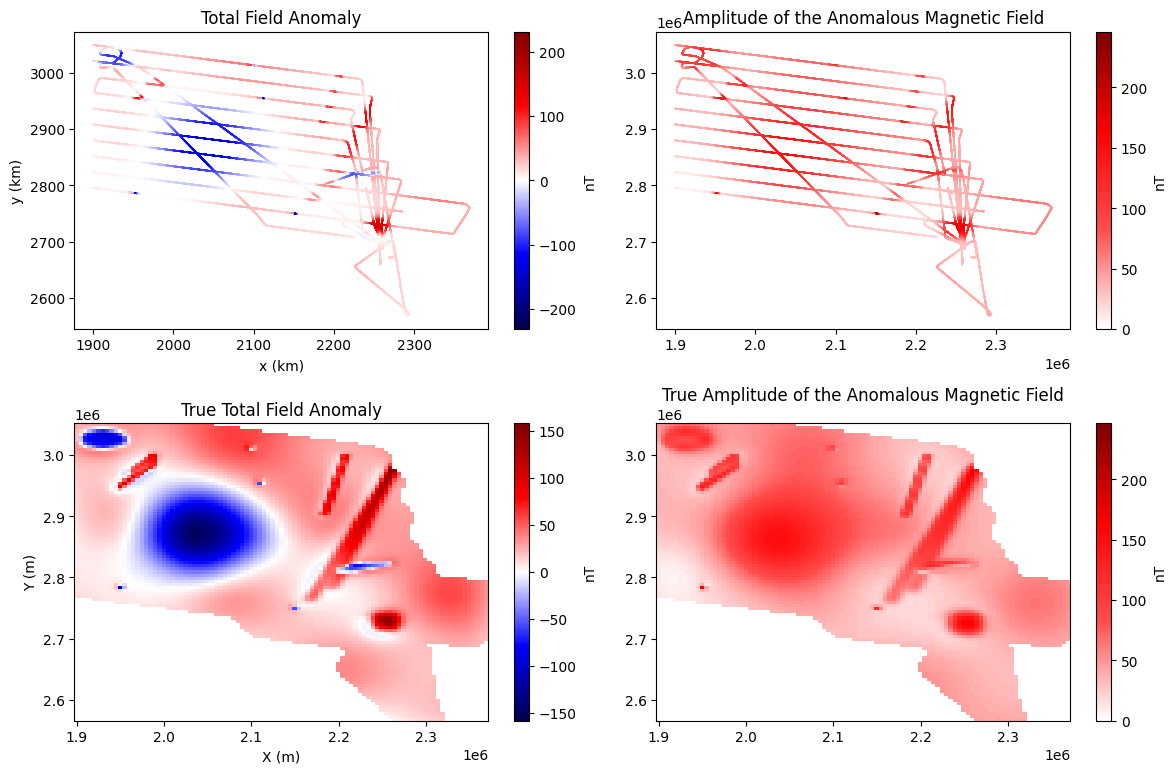

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))
scale_tfa_synthetic = vd.maxabs(icegrav_synthetic.tfa)
plot1 = ax[0,0].scatter(
    *coordinates_km[:2],
    c=icegrav_synthetic.tfa,
    cmap="seismic",
    s=0.01,
    vmin=-scale_tfa_synthetic,
    vmax=scale_tfa_synthetic,
)
ax[0,0].set_title("Total Field Anomaly")
ax[0,0].set_xlabel("x (km)")
ax[0,0].set_ylabel("y (km)")
fig.colorbar(plot1, ax=ax[0,0], label="nT")

scale_bnorm_synthetic = vd.maxabs(icegrav_synthetic.bnorm)
plot2 = ax[0,1].scatter(
    *coordinates[:2],
    c=icegrav_synthetic.bnorm,
    cmap=red_cm,
    s=0.01,
    norm=red_norm,
)
ax[0,1].set_title("Amplitude of the Anomalous Magnetic Field")
fig.colorbar(plot2, ax=ax[0,1], label="nT")

scale_true_tfa = vd.maxabs(true_tfa)
plot3 = ax[1, 0].pcolormesh(
    *grid_coordinates[:2],
    true_tfa,
    cmap="seismic",
    vmin=-scale_true_tfa,
    vmax=scale_true_tfa,
)
ax[1, 0].set_title("True Total Field Anomaly")
ax[1, 0].set_xlabel("X (m)")
ax[1, 0].set_ylabel("Y (m)")
fig.colorbar(plot3, ax=ax[1, 0], label="nT")

plot4 = ax[1, 1].pcolormesh(
    *grid_coordinates[:2],
    true_bnorm,
    cmap=red_cm,
    norm=red_norm,
)
ax[1, 1].set_title("True Amplitude of the Anomalous Magnetic Field")
fig.colorbar(plot4, ax=ax[1, 1], label="nT")

fig.tight_layout()
fig.show()

## Apply the single layer EQS

In [9]:
window_size = 250e3
dampings_1layer = [1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
depths_1layer = [20e3, 25e3, 30e3, 35e3, 40e3, 45e3, 50e3]

parameter_sets_1layer = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_1layer, depths_1layer)
]
print("Number of combinations:", len(parameter_sets_1layer))

Number of combinations: 42


In [10]:
%%time
kfold = vd.BlockKFold(
    spacing=30e3,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores_1layer = []
damping_1layer = []
source_depth_1layer = []
for parameters in parameter_sets_1layer:    
    print(parameters)
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(
        random_state=0, 
        block_size=grid_spacing,
        window_size=window_size,
        **parameters,
    )
    tmp = []
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            icegrav_synthetic.tfa[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.sqrt(np.nanmean((icegrav_synthetic.tfa[test] - predicted)**2)))
    scores_1layer.append(np.mean(tmp))
    damping_1layer.append(parameters['damping'])
    source_depth_1layer.append(parameters['depth'])

{'damping': 1.0, 'depth': 20000.0}
{'damping': 1.0, 'depth': 25000.0}
{'damping': 1.0, 'depth': 30000.0}
{'damping': 1.0, 'depth': 35000.0}
{'damping': 1.0, 'depth': 40000.0}
{'damping': 1.0, 'depth': 45000.0}
{'damping': 1.0, 'depth': 50000.0}
{'damping': 10.0, 'depth': 20000.0}
{'damping': 10.0, 'depth': 25000.0}
{'damping': 10.0, 'depth': 30000.0}
{'damping': 10.0, 'depth': 35000.0}
{'damping': 10.0, 'depth': 40000.0}
{'damping': 10.0, 'depth': 45000.0}
{'damping': 10.0, 'depth': 50000.0}
{'damping': 100.0, 'depth': 20000.0}
{'damping': 100.0, 'depth': 25000.0}
{'damping': 100.0, 'depth': 30000.0}
{'damping': 100.0, 'depth': 35000.0}
{'damping': 100.0, 'depth': 40000.0}
{'damping': 100.0, 'depth': 45000.0}
{'damping': 100.0, 'depth': 50000.0}
{'damping': 1000.0, 'depth': 20000.0}
{'damping': 1000.0, 'depth': 25000.0}
{'damping': 1000.0, 'depth': 30000.0}
{'damping': 1000.0, 'depth': 35000.0}
{'damping': 1000.0, 'depth': 40000.0}
{'damping': 1000.0, 'depth': 45000.0}
{'damping': 1000

Best parameters: {'damping': 100.0, 'depth': 35000.0}
Best RMSE: 15.379 nT


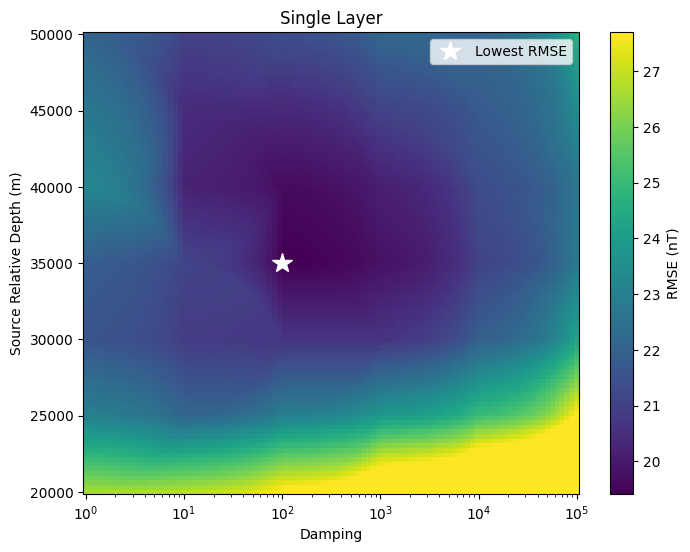

In [47]:
damping_values_1layer = np.array(damping_1layer)
depth_values_1layer = np.array(source_depth_1layer)
score_values_1layer = np.array(scores_1layer)

best_1layer = np.argmin(score_values_1layer)
best_damping_1layer = damping_values_1layer[best_1layer]
best_depth_1layer = depth_values_1layer[best_1layer]
best_rmse_1layer = score_values_1layer[best_1layer]
best_params_1layer = parameter_sets_1layer[best_1layer]
print("Best parameters:", best_params_1layer)
print(f"Best RMSE: {best_rmse:.3f} nT")

x_1layer = np.logspace(np.log10(damping_values_1layer.min()), np.log10(damping_values_1layer.max()), 100)
y_1layer = np.linspace(depth_values_1layer.min(), depth_values_1layer.max(), 100)
X_1layer, Y_1layer = np.meshgrid(x_1layer, y_1layer)

Z_1layer = griddata((damping_values_1layer, depth_values_1layer), score_values_1layer, (X_1layer, Y_1layer), method='linear')
plt.figure(figsize=(8, 6))
c = plt.pcolormesh(X_1layer, Y_1layer, Z_1layer, cmap="viridis", shading='auto', vmax=np.percentile(score_values_1layer, 90))
plt.plot(best_damping_1layer, best_depth_1layer, '*', color='white', markersize=15, label='Lowest RMSE')
plt.xscale('log')
plt.xlabel('Damping')
plt.ylabel('Source Relative Depth (m)')
plt.colorbar(c, label='RMSE (nT)')
plt.legend()
plt.title("Single Layer")
plt.show()

In [12]:
%%time
eqs_shallow_1layer = eqs.EquivalentSourcesMagneticGB(
    random_state=0,
    block_size=grid_spacing,
    window_size=window_size,
    **parameter_sets_1layer[best_1layer],
    repeat=2,
)
eqs_shallow_1layer.fit(coordinates, icegrav_synthetic.tfa, field_direction)
print("dipole height:", eqs_shallow.dipole_coordinates_[2][0])
print("window size:", eqs_shallow.window_size_)

dipole height: -47114.9
window size: 250000.0
CPU times: user 1min 18s, sys: 22.8 s, total: 1min 41s
Wall time: 7.42 s


In [13]:
tfa_predicted_1layer = eqs.total_field_anomaly(
    eqs_shallow_1layer.predict(coordinates),
    field_direction
)
error_tfa_1layer = icegrav_synthetic.tfa - tfa_predicted_1layer
rmse_tfa_1layer = np.sqrt(np.nanmean((error_tfa_1layer)**2))
nrmse_tfa_1layer = rmse_tfa_1layer / (np.nanmax(icegrav_synthetic.tfa) - np.nanmin(icegrav_synthetic.tfa))

predicted_b_grid_1layer = eqs_shallow_1layer.predict(grid_coords_masked)
predicted_tfa_grid_1layer = eqs.total_field_anomaly(predicted_b_grid_1layer, field_direction)
error_tfa_grid_1layer = true_tfa - predicted_tfa_grid_1layer
rmse_tfa_grid_1layer = np.sqrt(np.nanmean((error_tfa_grid_1layer)**2))
nrmse_tfa_grid_1layer = rmse_tfa_grid_1layer / (np.nanmax(true_tfa) - np.nanmin(true_tfa))

predicted_bnorm_grid_1layer = np.sqrt(sum(c**2 for c in predicted_b_grid_1layer))
error_bnorm_grid_1layer = true_bnorm - predicted_bnorm_grid_1layer
rmse_bnorm_grid_1layer = np.sqrt(np.nanmean((error_bnorm_grid_1layer)**2))
nrmse_bnorm_grid_1layer = rmse_bnorm_grid_1layer / (np.nanmax(true_bnorm) - np.nanmin(true_bnorm))

/tmp/ipykernel_60576/1665429160.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


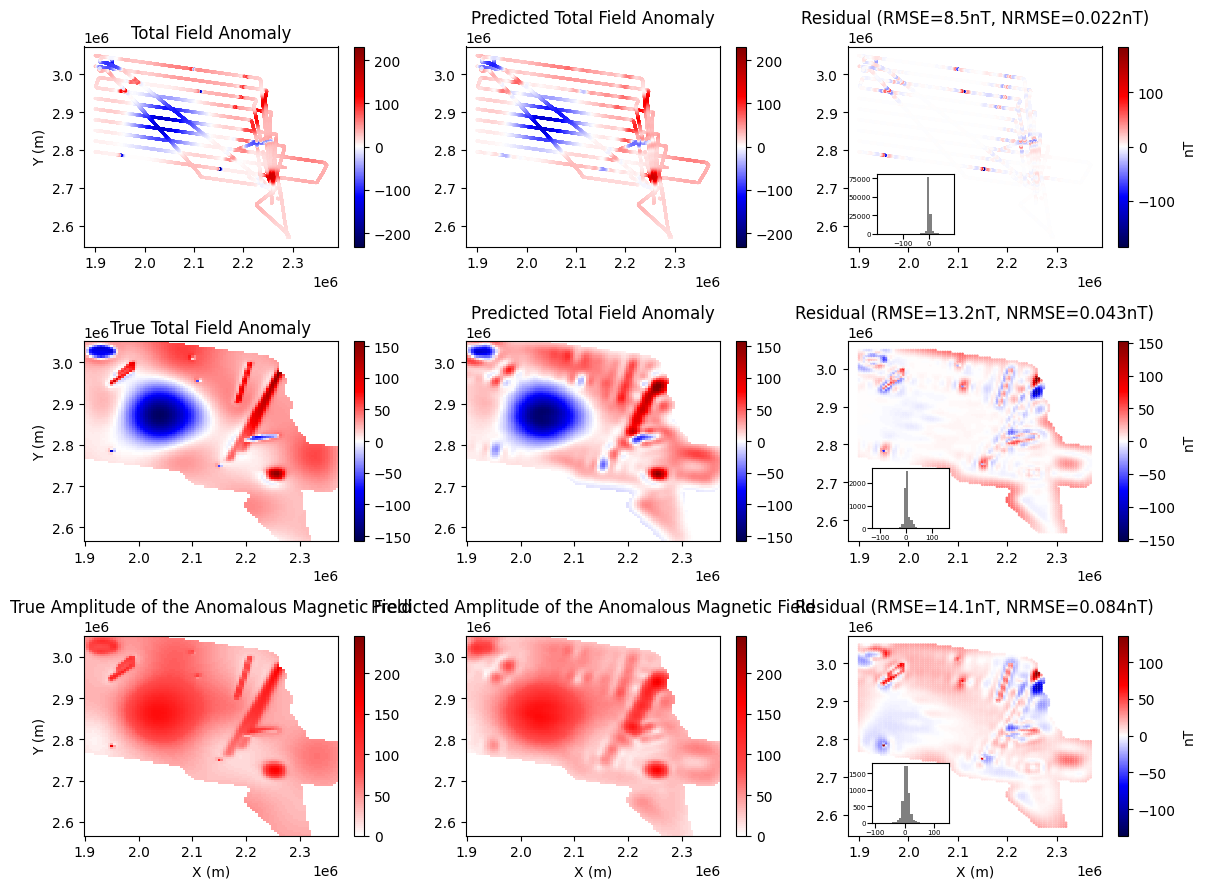

In [14]:
fig, ax = plt.subplots(3, 3, figsize=(12,9))
plot1 = ax[0,0].scatter(
    *coordinates[:2],
    c=icegrav_synthetic.tfa,
    cmap="seismic",
    s=1,
    vmin=-scale_tfa_synthetic,
    vmax=scale_tfa_synthetic,
)
ax[0,0].set_title("Total Field Anomaly")
ax[0,0].set_ylabel("Y (m)")
fig.colorbar(plot1, ax=ax[0,0])

scale_tfa_1layer = vd.maxabs(tfa_predicted_1layer)
plot2 = ax[0,1].scatter(
    *coordinates[:2],
    c=tfa_predicted_1layer,
    cmap="seismic",
    s=1,
    vmin=-scale_tfa_synthetic,
    vmax=scale_tfa_synthetic,
)
ax[0,1].set_title("Predicted Total Field Anomaly")
fig.colorbar(plot2, ax=ax[0,1])

scale_error_tfa_1layer = vd.maxabs(error_tfa_1layer)
plot3 = ax[0,2].scatter(
    *coordinates[:2],
    c=error_tfa_1layer,
    cmap="seismic",
    s=1,
    vmin=-scale_error_tfa_1layer,
    vmax=scale_error_tfa_1layer,
)
ax[0,2].set_title(f'Residual (RMSE={np.round(rmse_tfa_1layer,1)}nT, NRMSE={np.round(nrmse_tfa_1layer, 3)}nT)')
fig.colorbar(plot3, ax=ax[0,2], label="nT")

plot4 = ax[1, 0].pcolormesh(
    *grid_coordinates[:2],
    true_tfa,
    cmap="seismic",
    vmin=-scale_true_tfa,
    vmax=scale_true_tfa,
)
ax[1, 0].set_title("True Total Field Anomaly")
ax[1, 0].set_ylabel("Y (m)")
fig.colorbar(plot4, ax=ax[1, 0])

plot5 = ax[1, 1].pcolormesh(
    *grid_coordinates[:2],
    predicted_tfa_grid_1layer,
    cmap="seismic",
    vmin=-scale_true_tfa,
    vmax=scale_true_tfa,
)
ax[1, 1].set_title("Predicted Total Field Anomaly")
fig.colorbar(plot5, ax=ax[1, 1])

scale_error_tfa_grid_1layer = vd.maxabs(error_tfa_grid_1layer)
plot6 = ax[1,2].scatter(
    *grid_coordinates[:2],
    c=error_tfa_grid_1layer,
    cmap="seismic",
    s=1,
    vmin=-scale_error_tfa_grid_1layer,
    vmax=scale_error_tfa_grid_1layer,
)
ax[1,2].set_title(f'Residual (RMSE={np.round(rmse_tfa_grid_1layer,1)}nT, NRMSE={np.round(nrmse_tfa_grid_1layer, 3)}nT)')
fig.colorbar(plot6, ax=ax[1,2], label="nT")

plot7 = ax[2, 0].pcolormesh(
    *grid_coordinates[:2],
    true_bnorm,
    cmap=red_cm,
    norm=red_norm,
)
ax[2, 0].set_title("True Amplitude of the Anomalous Magnetic Field")
ax[2, 0].set_xlabel("X (m)")
ax[2, 0].set_ylabel("Y (m)")
fig.colorbar(plot7, ax=ax[2, 0])

plot8 = ax[2, 1].pcolormesh(
    *grid_coordinates[:2],
    predicted_bnorm_grid_1layer,
    cmap=red_cm,
    norm=red_norm,
)
ax[2, 1].set_title("Predicted Amplitude of the Anomalous Magnetic Field")
ax[2, 1].set_xlabel("X (m)")
fig.colorbar(plot8, ax=ax[2, 1])

scale_error_bnorm_grid_1layer = vd.maxabs(error_bnorm_grid_1layer)
plot9 = ax[2,2].scatter(
    *grid_coordinates[:2],
    c=error_bnorm_grid_1layer,
    cmap="seismic",
    s=1,
    vmin=-scale_error_bnorm_grid_1layer,
    vmax=scale_error_bnorm_grid_1layer,
)
ax[2,2].set_title(f'Residual (RMSE={np.round(rmse_bnorm_grid_1layer,1)}nT, NRMSE={np.round(nrmse_bnorm_grid_1layer, 3)}nT)')
ax[2, 2].set_xlabel("X (m)")
fig.colorbar(plot9, ax=ax[2, 2], label="nT")

# Add histograms to residual plots
inset1 = inset_axes(ax[0, 2], width="30%", height="30%", bbox_to_anchor=(0.09, 0.03, 1, 1), bbox_transform=ax[0, 2].transAxes, loc="lower left")
inset1.hist(error_tfa_1layer.ravel(), bins=30, color="gray")
inset1.tick_params(labelsize=5, pad=1)

inset2 = inset_axes(ax[1, 2], width="30%", height="30%", bbox_to_anchor=(0.07, 0.03, 1, 1), bbox_transform=ax[1, 2].transAxes, loc="lower left")
inset2.hist(error_tfa_grid_1layer.ravel(), bins=30, color="gray")
inset2.tick_params(labelsize=5, pad=1)

inset3 = inset_axes(ax[2, 2], width="30%", height="30%", bbox_to_anchor=(0.07, 0.03, 1, 1), bbox_transform=ax[2, 2].transAxes, loc="lower left")
inset3.hist(error_bnorm_grid_1layer.ravel(), bins=30, color="gray")
inset3.tick_params(labelsize=5, pad=1)

fig.tight_layout()
fig.show()

## Apply the dual-layer GB EQS approach

### Fit the deep EQS

In [15]:
block_spacing = 25e3
reducer = vd.BlockReduce(
    reduction=np.median,
    spacing=block_spacing,
    region=(vd.pad_region(region, pad=block_spacing*0.2)),
    drop_coords=False
)
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=icegrav_synthetic.tfa)

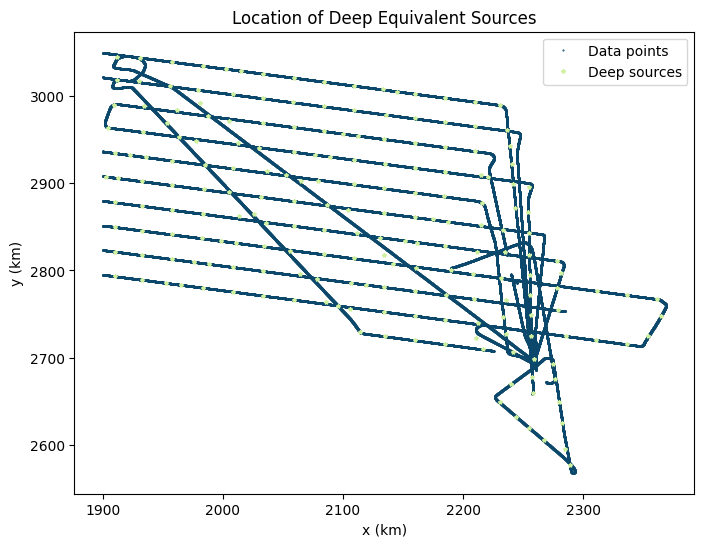

In [16]:
coords_blocked_km = [coord / 1000 for coord in coords_blocked]
plt.figure(figsize=(8,6))
plt.plot(*coordinates_km[:2], ".", color="#0B486B", markersize=1, label='Data points')
plt.plot(*coords_blocked_km[:2], "*", color="#cff09e", markersize=3, label='Deep sources')
plt.title("Location of Deep Equivalent Sources")
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.legend()
plt.show()

In [17]:
spacing = np.mean(vd.median_distance(coords_blocked))
#depths_deep = [spacing*2.5, spacing*3, spacing*3.5, spacing*4, spacing*4.5, spacing*5, spacing*5.5, spacing*6]
depths_deep = [spacing*6, spacing*6.5, spacing*7, spacing*7.5, spacing*8, spacing*8.5, spacing*9]
dampings_deep = [1e-2, 1e-1, 1e0, 1e1, 1e2]

In [18]:
parameter_sets_deep = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_deep, depths_deep)
]
print("Number of combinations:", len(parameter_sets_deep))

Number of combinations: 35


In [19]:
%%time
kfold = vd.BlockKFold(
    spacing=100e3,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coords_blocked[:2])
scores_deep = []
damping_deep = []
source_depth_deep = []
for parameters in parameter_sets_deep:    
    # print(parameters)
    eqs_deep = eqs.EquivalentSourcesMagnetic(**parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_deep.fit(
            [c[train] for c in coords_blocked], 
            tfa_blocked[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_deep.predict([c[test] for c in coords_blocked]),
            field_direction,
        )
        tmp.append(np.sqrt(np.nanmean((tfa_blocked[test] - predicted)**2)))
    scores_deep.append(np.mean(tmp))
    damping_deep.append(parameters['damping'])
    source_depth_deep.append(parameters['depth'])

CPU times: user 6min 1s, sys: 3min 7s, total: 9min 8s
Wall time: 15.4 s


Best parameters: {'damping': 100.0, 'depth': 17000.0}
Best RMSE: 15.379 nT


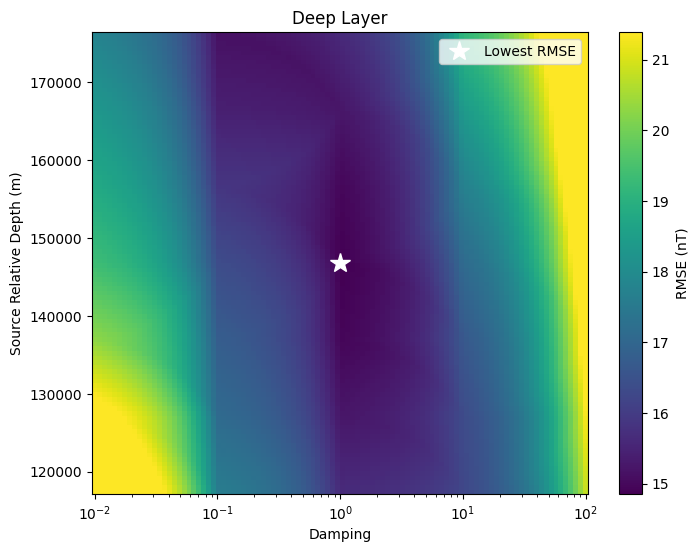

In [46]:
damping_values_deep = np.array(damping_deep)
depth_values_deep = np.array(source_depth_deep)
score_values_deep = np.array(scores_deep)

best_deep = np.argmin(score_values_deep)
best_damping_deep = damping_values_deep[best_deep]
best_depth_deep = depth_values_deep[best_deep]
best_rmse_deep = score_values_deep[best_deep]
best_params_deep = parameter_sets_deep[best_deep]
print("Best parameters:", best_params)
print(f"Best RMSE: {best_rmse:.3f} nT")

x_deep = np.logspace(np.log10(damping_values_deep.min()), np.log10(damping_values_deep.max()), 100)
y_deep = np.linspace(depth_values_deep.min(), depth_values_deep.max(), 100)
X_deep, Y_deep = np.meshgrid(x_deep, y_deep)

Z_deep = griddata((damping_values_deep, depth_values_deep), score_values_deep, (X_deep, Y_deep), method='linear')
plt.figure(figsize=(8, 6))
c = plt.pcolormesh(X_deep, Y_deep, Z_deep, cmap="viridis", shading='auto', vmax=np.percentile(score_values_deep, 80))
plt.plot(best_damping_deep, best_depth_deep, '*', color='white', markersize=15, label='Lowest RMSE')
plt.xscale('log')
plt.xlabel('Damping')
plt.ylabel('Source Relative Depth (m)')
plt.colorbar(c, label='RMSE (nT)')
plt.legend()
plt.title("Deep Layer")
plt.show()

In [21]:
%%time
eqs_deep = eqs.EquivalentSourcesMagnetic(**parameter_sets_deep[best_deep])
eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
print("source height:", eqs_deep.dipole_coordinates_[2][0])

tfa_deep_blocked = eqs.total_field_anomaly(eqs_deep.predict(coords_blocked), field_direction)
tfa_deep = eqs.total_field_anomaly(eqs_deep.predict(coordinates), field_direction)
tfa_residuals = icegrav_synthetic.tfa - tfa_deep

tfa_deep_grid = eqs.total_field_anomaly(eqs_deep.predict(grid_coords_masked), field_direction)
tfa_residuals_grid = true_tfa - tfa_deep_grid

source height: -143893.5795761045
CPU times: user 2.94 s, sys: 1.17 s, total: 4.11 s
Wall time: 117 ms


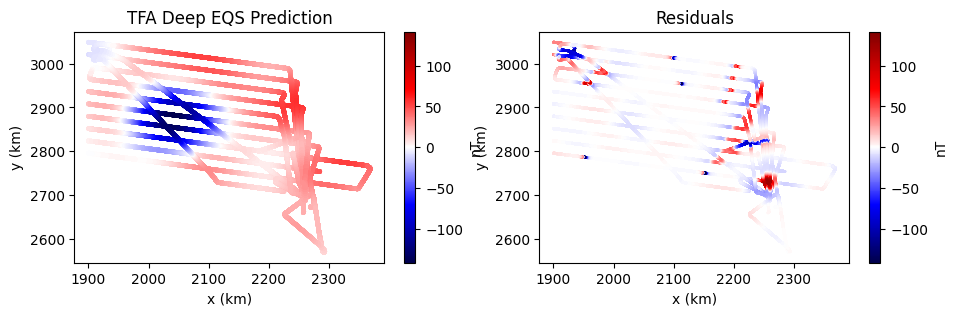

In [22]:
plt.figure(figsize=(11,3))
plt.subplot(1,2,1)
scale_tfa_deep = vd.maxabs(tfa_deep)
plt.scatter(*coordinates_km[:2], c=tfa_deep, cmap="seismic", s=5, vmin=-scale_tfa_deep, vmax=scale_tfa_deep)
plt.title("TFA Deep EQS Prediction")
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
scale_tfa_residuals = vd.maxabs(tfa_residuals)
plt.scatter(*coordinates_km[:2], c=tfa_residuals, cmap="seismic", s=1, vmin=-scale_tfa_deep, vmax=scale_tfa_deep)
plt.title("Residuals")
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.colorbar(label="nT")
plt.show()

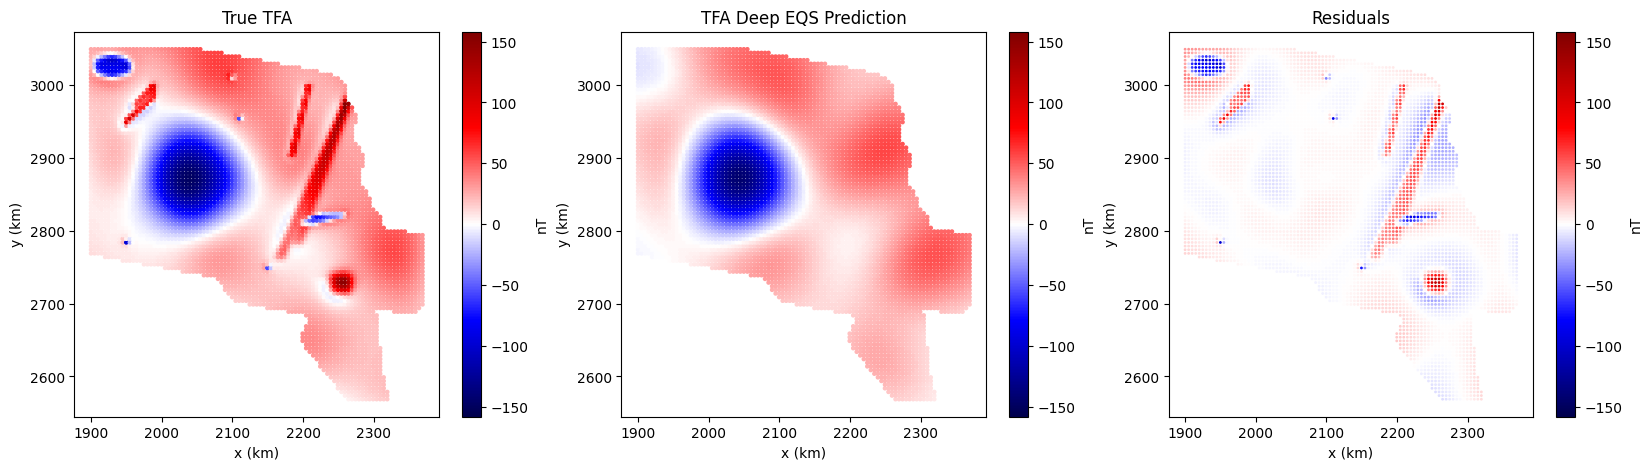

In [23]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.scatter(*grid_coords_masked_km[:2], c=true_tfa, cmap="seismic", s=5, vmin=-scale_true_tfa, vmax=scale_true_tfa)
plt.title("True TFA")
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.colorbar(label="nT")
plt.subplot(1,3,2)
# scale = vd.maxabs(tfa_deep_grid)
plt.scatter(*grid_coords_masked_km[:2], c=tfa_deep_grid, cmap="seismic", s=5, vmin=-scale_true_tfa, vmax=scale_true_tfa)
plt.title("TFA Deep EQS Prediction")
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.colorbar(label="nT")
plt.subplot(1,3,3)
scale_tfa_residual_grid = vd.maxabs(tfa_residuals_grid)
plt.scatter(*grid_coords_masked_km[:2], c=tfa_residuals_grid, cmap="seismic", s=1, vmin=-scale_true_tfa, vmax=scale_true_tfa)
plt.title("Residuals")
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.colorbar(label="nT")
plt.show()

### Fit the deep residuals with the shallow GB EQS layer

In [24]:
dampings_shallow = [1e0, 1e1, 1e2, 1e3, 1e4]
depths_shallow = [15e3, 16e3, 17e3, 18e3, 19e3]

parameter_sets_shallow = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_shallow, depths_shallow)
]
print("Number of combinations:", len(parameter_sets_shallow))

Number of combinations: 25


In [25]:
%%time
kfold = vd.BlockKFold(
    spacing=30e3,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores_shallow = []
damping_shallow = []
source_depth_shallow = []
for parameters in parameter_sets_shallow:    
    print(parameters)
    tmp = []
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(
            random_state=0,
            block_size=grid_spacing,
            window_size=window_size,
            damping=parameters['damping'],
            depth=parameters['depth'],
    )
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa_residuals[train],
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.sqrt(np.nanmean((tfa_residuals[test] - predicted)**2)))
    scores_shallow.append(np.mean(tmp))
    damping_shallow.append(parameters['damping'])
    source_depth_shallow.append(parameters['depth'])

{'damping': 1.0, 'depth': 15000.0}
{'damping': 1.0, 'depth': 16000.0}
{'damping': 1.0, 'depth': 17000.0}
{'damping': 1.0, 'depth': 18000.0}
{'damping': 1.0, 'depth': 19000.0}
{'damping': 10.0, 'depth': 15000.0}
{'damping': 10.0, 'depth': 16000.0}
{'damping': 10.0, 'depth': 17000.0}
{'damping': 10.0, 'depth': 18000.0}
{'damping': 10.0, 'depth': 19000.0}
{'damping': 100.0, 'depth': 15000.0}
{'damping': 100.0, 'depth': 16000.0}
{'damping': 100.0, 'depth': 17000.0}
{'damping': 100.0, 'depth': 18000.0}
{'damping': 100.0, 'depth': 19000.0}
{'damping': 1000.0, 'depth': 15000.0}
{'damping': 1000.0, 'depth': 16000.0}
{'damping': 1000.0, 'depth': 17000.0}
{'damping': 1000.0, 'depth': 18000.0}
{'damping': 1000.0, 'depth': 19000.0}
{'damping': 10000.0, 'depth': 15000.0}
{'damping': 10000.0, 'depth': 16000.0}
{'damping': 10000.0, 'depth': 17000.0}
{'damping': 10000.0, 'depth': 18000.0}
{'damping': 10000.0, 'depth': 19000.0}
CPU times: user 1h 8min 54s, sys: 21min 43s, total: 1h 30min 37s
Wall time:

Best parameters: {'damping': 100.0, 'depth': 17000.0}
Best RMSE: 15.379 nT


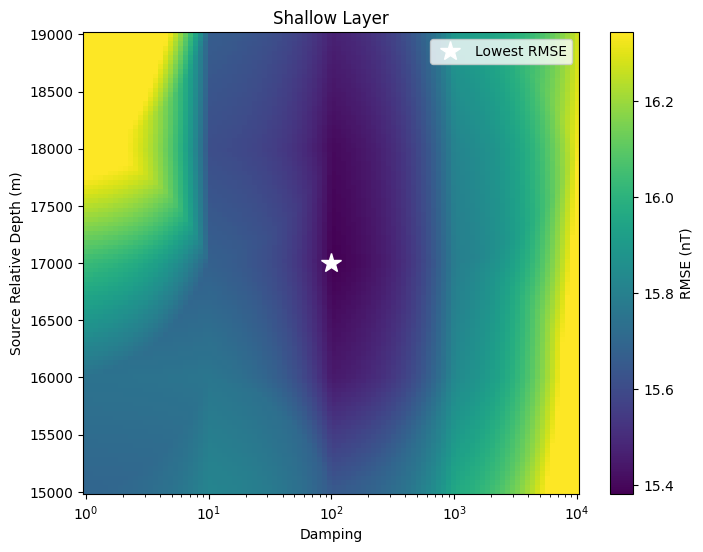

In [40]:
damping_values_shallow = np.array(damping_shallow)
depth_values_shallow = np.array(source_depth_shallow)
score_values_shallow = np.array(scores_shallow)

best_shallow = np.argmin(score_values_shallow)
best_damping_shallow = damping_values_shallow[best_shallow]
best_depth_shallow = depth_values_shallow[best_shallow]
best_rmse_shallow = score_values_shallow[best_shallow]
best_params_shallow = parameter_sets_shallow[best_shallow]
print("Best parameters:", best_params_shallow)
print(f"Best RMSE: {best_rmse:.3f} nT")

x_shallow = np.logspace(np.log10(damping_values_shallow.min()), np.log10(damping_values_shallow.max()), 100)
y_shallow = np.linspace(depth_values_shallow.min(), depth_values_shallow.max(), 100)
X_shallow, Y_shallow = np.meshgrid(x_shallow, y_shallow)

Z_shallow = griddata((damping_values_shallow, depth_values_shallow), score_values_shallow, (X_shallow, Y_shallow), method='linear')
plt.figure(figsize=(8, 6))
c = plt.pcolormesh(X_shallow, Y_shallow, Z_shallow, cmap="viridis", shading='auto', vmax=np.percentile(score_values, 80))
plt.plot(best_damping_shallow, best_depth_shallow, '*', color='white', markersize=15, label='Lowest RMSE')
plt.xscale('log')
plt.xlabel('Damping')
plt.ylabel('Source Relative Depth (m)')
plt.colorbar(c, label='RMSE (nT)')
plt.legend()
plt.title("Shallow Layer")
plt.show()

In [34]:
%%time
eqs_shallow = eqs.EquivalentSourcesMagneticGB(
    random_state=0,
    block_size=grid_spacing,
    window_size=window_size,
    damping=parameter_sets_shallow[best_shallow]['damping'],
    depth=parameter_sets_shallow[best_shallow]['depth'],
    repeat=2,
)
eqs_shallow.fit(coordinates, tfa_residuals, field_direction)

CPU times: user 1min 16s, sys: 22.5 s, total: 1min 39s
Wall time: 7.77 s


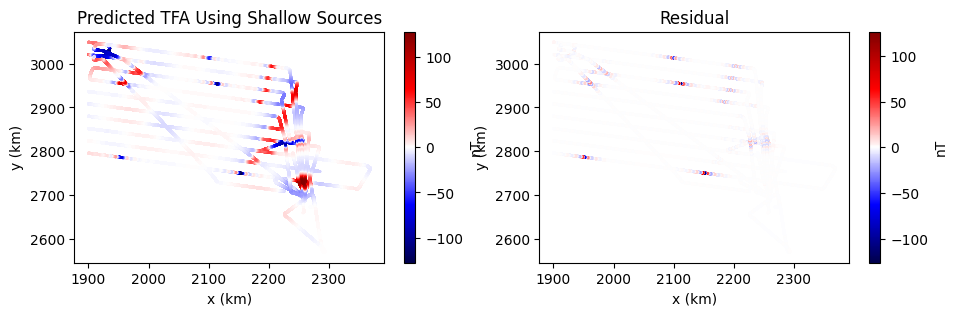

In [35]:
tfa_shallow_predicted = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)

plt.figure(figsize=(11,3))
scale_shallow_predicted = vd.maxabs(tfa_shallow_predicted)
plt.subplot(1,2,1)
plt.scatter(*coordinates_km[:2], c=tfa_shallow_predicted, cmap="seismic", s=1, vmin=-scale_shallow_predicted, vmax=scale_shallow_predicted)
plt.title("Predicted TFA Using Shallow Sources")
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
error_shallow_predicted = tfa_residuals - tfa_shallow_predicted
scale_error_shallow_predicted = vd.maxabs(error_shallow_predicted)
plt.scatter(*coordinates_km[:2], c=error_shallow_predicted, cmap="seismic", s=1, vmin=-scale_error_shallow_predicted, vmax=scale_error_shallow_predicted)
plt.title("Residual")
plt.xlabel( "x (km)")
plt.ylabel("y (km)")
plt.colorbar(label="nT")
plt.show()

### Dual Layer Prediction

In [36]:
predicted_tfa = eqs.total_field_anomaly(
    (eqs_deep.predict(coordinates) + eqs_shallow.predict(coordinates)),
    field_direction,
)
error_tfa = icegrav_synthetic.tfa - predicted_tfa
rmse_tfa = np.sqrt(np.nanmean((error_tfa)**2))
nrmse_tfa = rmse_tfa / (np.nanmax(icegrav_synthetic.tfa) - np.nanmin(icegrav_synthetic.tfa))

predicted_b_grid = eqs_deep.predict(grid_coords_masked) + eqs_shallow.predict(grid_coords_masked)
predicted_tfa_grid = eqs.total_field_anomaly(predicted_b_grid, field_direction)
error_tfa_grid = true_tfa - predicted_tfa_grid
rmse_tfa_grid = np.sqrt(np.nanmean((error_tfa_grid)**2))
nrmse_tfa_grid = rmse_tfa_grid / (np.nanmax(true_tfa) - np.nanmin(true_tfa))

predicted_bnorm_grid = np.sqrt(sum(c**2 for c in predicted_b_grid))
error_bnorm_grid = true_bnorm - predicted_bnorm_grid
rmse_bnorm_grid = np.sqrt(np.nanmean((error_tfa_grid)**2))
nrmse_bnorm_grid = rmse_bnorm_grid / (np.nanmax(true_bnorm) - np.nanmin(true_bnorm))

/tmp/ipykernel_60576/3287928956.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


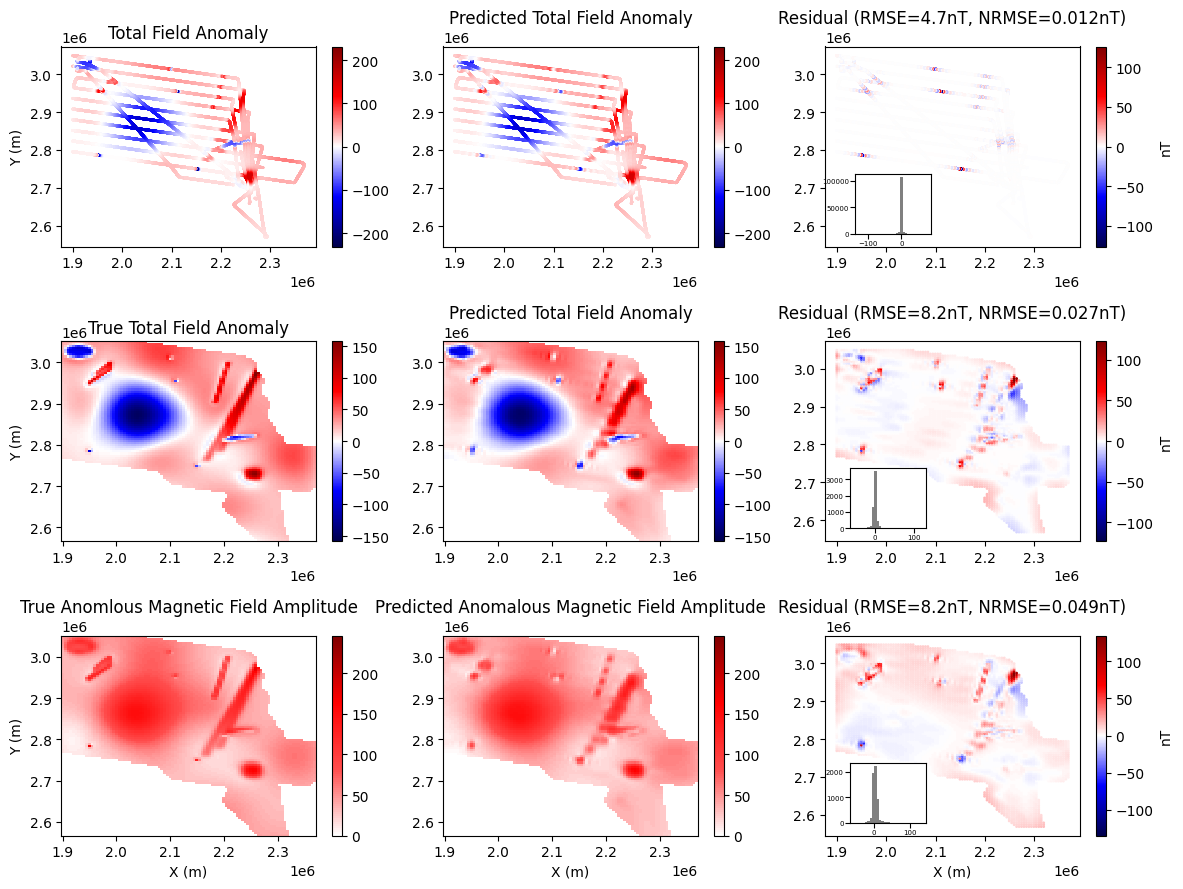

In [37]:
fig, ax = plt.subplots(3, 3, figsize=(12,9))
plot1 = ax[0,0].scatter(
    *coordinates[:2],
    c=icegrav_synthetic.tfa,
    cmap="seismic",
    s=1,
    vmin=-scale_tfa_synthetic,
    vmax=scale_tfa_synthetic,
)
ax[0,0].set_title("Total Field Anomaly")
ax[0,0].set_ylabel("Y (m)")
fig.colorbar(plot1, ax=ax[0,0])

plot2 = ax[0,1].scatter(
    *coordinates[:2],
    c=predicted_tfa,
    cmap="seismic",
    s=1,
    vmin=-scale_tfa_synthetic,
    vmax=scale_tfa_synthetic,
)
ax[0,1].set_title("Predicted Total Field Anomaly")
fig.colorbar(plot2, ax=ax[0,1])

scale_error_tfa = vd.maxabs(error_tfa)
plot3 = ax[0,2].scatter(
    *coordinates[:2],
    c=error_tfa,
    cmap="seismic",
    s=1,
    vmin=-scale_error_tfa,
    vmax=scale_error_tfa,
)
ax[0,2].set_title(f'Residual (RMSE={np.round(rmse_tfa,1)}nT, NRMSE={np.round(nrmse_tfa, 3)}nT)')
fig.colorbar(plot3, ax=ax[0,2], label="nT")

plot4 = ax[1, 0].pcolormesh(
    *grid_coordinates[:2],
    true_tfa,
    cmap="seismic",
    vmin=-scale_true_tfa,
    vmax=scale_true_tfa,
)
ax[1, 0].set_title("True Total Field Anomaly")
ax[1, 0].set_ylabel("Y (m)")
fig.colorbar(plot4, ax=ax[1, 0])

plot5 = ax[1, 1].pcolormesh(
    *grid_coordinates[:2],
    predicted_tfa_grid,
    cmap="seismic",
    vmin=-scale_true_tfa,
    vmax=scale_true_tfa,
)
ax[1, 1].set_title("Predicted Total Field Anomaly")
fig.colorbar(plot5, ax=ax[1, 1])

scale_error_tfa_grid = vd.maxabs(error_tfa_grid)
plot6 = ax[1,2].scatter(
    *grid_coordinates[:2],
    c=error_tfa_grid,
    cmap="seismic",
    s=1,
    vmin=-scale_error_tfa_grid,
    vmax=scale_error_tfa_grid,
)
ax[1,2].set_title(f'Residual (RMSE={np.round(rmse_tfa_grid,1)}nT, NRMSE={np.round(nrmse_tfa_grid,3)}nT)')
fig.colorbar(plot6, ax=ax[1,2], label="nT")

plot7 = ax[2, 0].pcolormesh(
    *grid_coordinates[:2],
    true_bnorm,
    cmap=red_cm,
    norm=red_norm,
)
ax[2, 0].set_title("True Anomlous Magnetic Field Amplitude")
ax[2, 0].set_xlabel("X (m)")
ax[2, 0].set_ylabel("Y (m)")
fig.colorbar(plot7, ax=ax[2, 0])

plot8 = ax[2, 1].pcolormesh(
    *grid_coordinates[:2],
    predicted_bnorm_grid,
    cmap=red_cm,
    norm=red_norm,
)
ax[2, 1].set_title("Predicted Anomalous Magnetic Field Amplitude")
ax[2, 1].set_xlabel("X (m)")
fig.colorbar(plot8, ax=ax[2, 1])

scale_error_bnorm_grid = vd.maxabs(error_bnorm_grid)
plot9 = ax[2,2].scatter(
    *grid_coordinates[:2],
    c=error_bnorm_grid,
    cmap="seismic",
    s=1,
    vmin=-scale_error_bnorm_grid,
    vmax=scale_error_bnorm_grid,
)
ax[2,2].set_title(f'Residual (RMSE={np.round(rmse_bnorm_grid,1)}nT, NRMSE={np.round(nrmse_bnorm_grid,3)}nT)')
ax[2, 2].set_xlabel("X (m)")
fig.colorbar(plot9, ax=ax[2, 2], label="nT")

# Add histograms to residual plots
inset1 = inset_axes(ax[0, 2], width="30%", height="30%", bbox_to_anchor=(0.09, 0.03, 1, 1), bbox_transform=ax[0, 2].transAxes, loc="lower left")
inset1.hist(error_tfa.ravel(), bins=30, color="gray")
inset1.tick_params(labelsize=5, pad=1)

inset2 = inset_axes(ax[1, 2], width="30%", height="30%", bbox_to_anchor=(0.07, 0.03, 1, 1), bbox_transform=ax[1, 2].transAxes, loc="lower left")
inset2.hist(error_tfa_grid.ravel(), bins=30, color="gray")
inset2.tick_params(labelsize=5, pad=1)

inset3 = inset_axes(ax[2, 2], width="30%", height="30%", bbox_to_anchor=(0.07, 0.03, 1, 1), bbox_transform=ax[2, 2].transAxes, loc="lower left")
inset3.hist(error_bnorm_grid.ravel(), bins=30, color="gray")
inset3.tick_params(labelsize=5, pad=1)

fig.tight_layout()
fig.show()

## Figures for paper

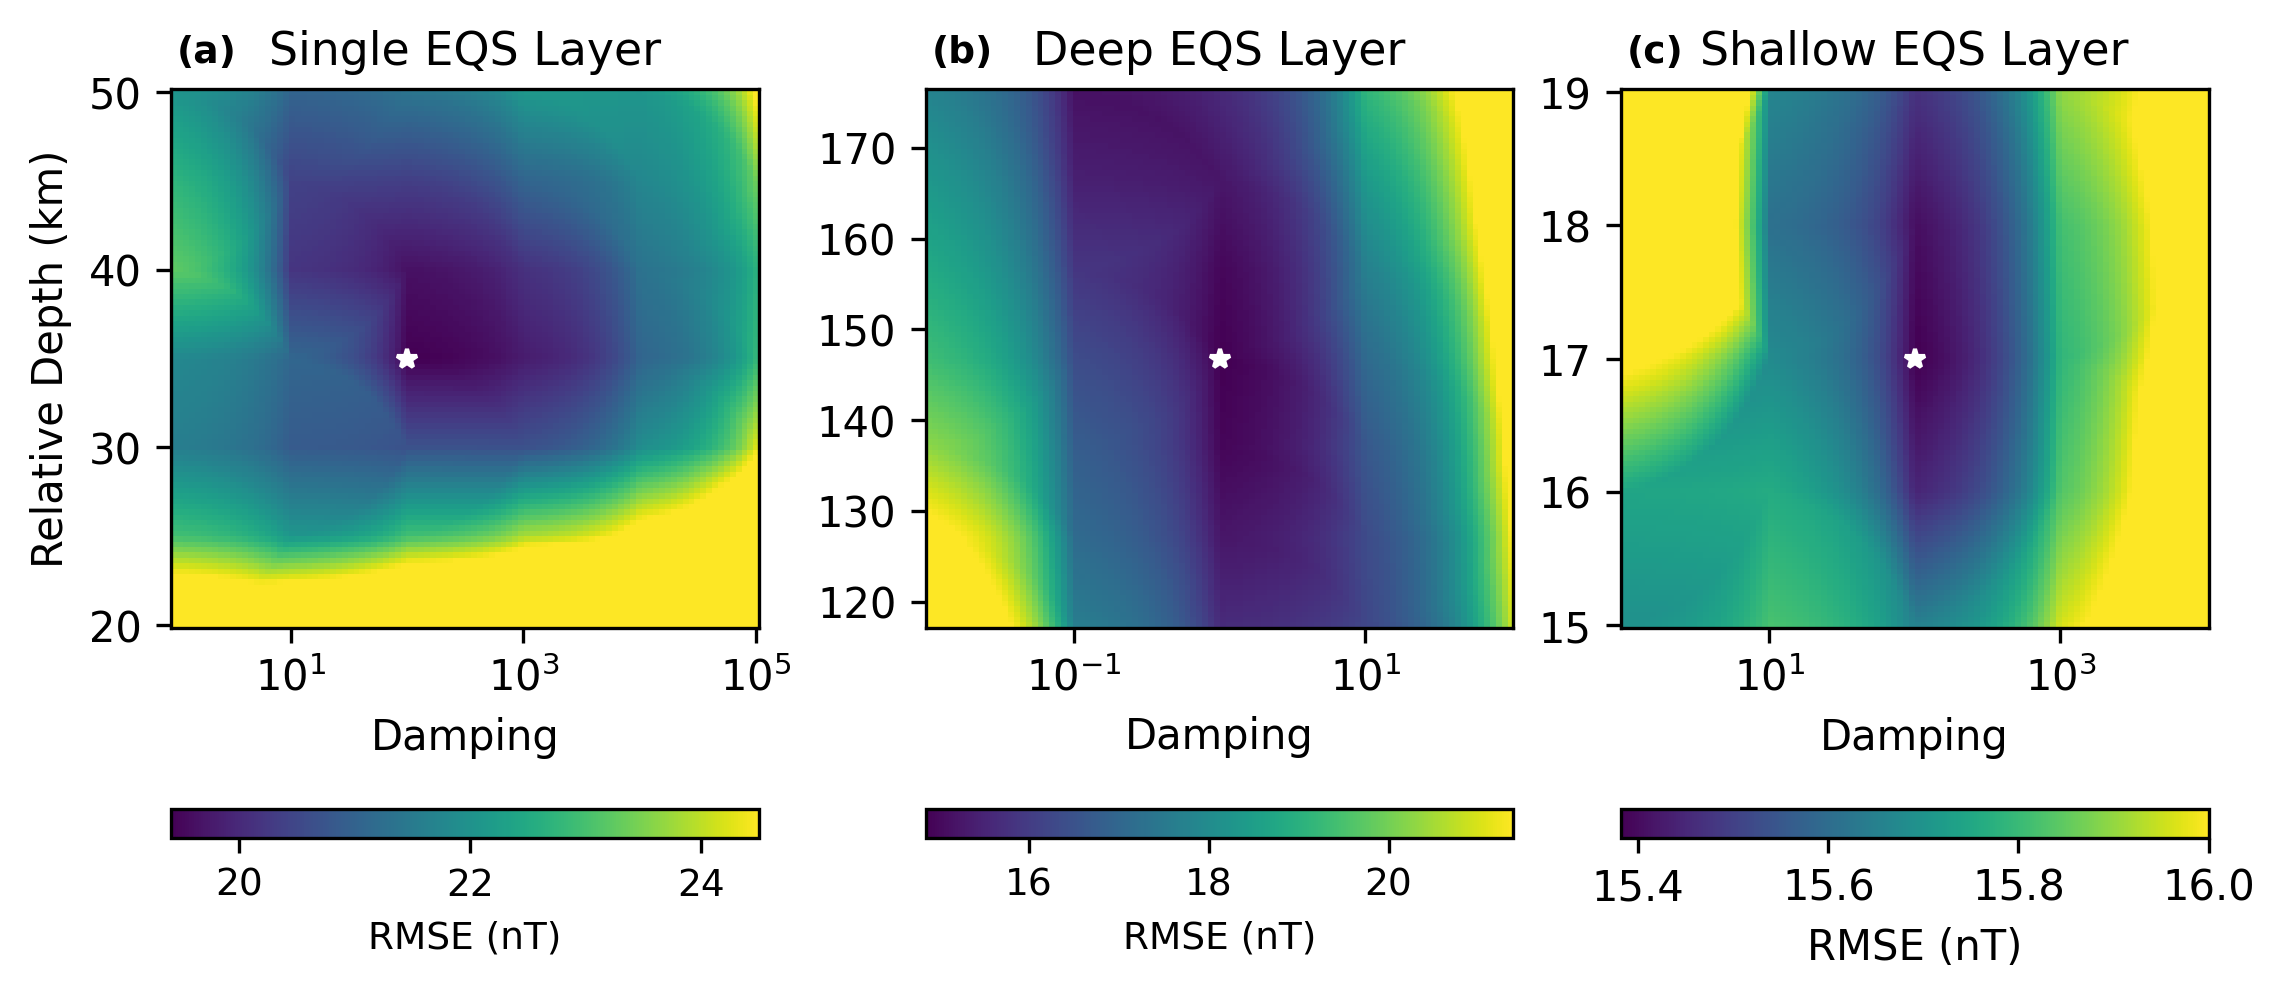

In [124]:
Y_1layer_km = [depth / 1000 for depth in Y_1layer]
Y_deep_km = [depth / 1000 for depth in Y_deep]
Y_shallow_km = [depth / 1000 for depth in Y_shallow]

fig, axes = plt.subplots(1, 3, figsize=(7.5, 3.2), layout="constrained")

plot1 = axes[0].pcolormesh(
    X_1layer,
    Y_1layer_km,
    Z_1layer,
    cmap="viridis",
    shading='auto',
    vmax=np.percentile(score_values_1layer, 80),
)
axes[0].plot(best_damping_1layer, best_depth_1layer/1000, '*', color='white', markersize=5, label='Lowest RMSE')
axes[0].set_xscale('log')
axes[0].set_xlabel('Damping', fontsize=10)
axes[0].set_ylabel('Relative Depth (km)', fontsize=10)
axes[0].set_title("Single EQS Layer", fontsize=11)
axes[0].text(0.01, 1.05, '(a)', transform=axes[0].transAxes, fontsize=9, fontweight='bold')
cbar1 = fig.colorbar(plot1, ax=axes[0], orientation='horizontal', location='bottom', label='RMSE (nT)', pad=0.08)
cbar1.set_label('RMSE (nT)', fontsize=9)
cbar1.ax.tick_params(labelsize=9)

plot2 = axes[1].pcolormesh(
    X_deep,
    Y_deep_km,
    Z_deep,
    cmap="viridis",
    shading='auto',
    vmax=np.percentile(score_values_deep, 80),
)
axes[1].plot(best_damping_deep, best_depth_deep/1000, '*', color='white', markersize=5, label='Lowest RMSE')
axes[1].set_xscale('log')
axes[1].set_xlabel('Damping', fontsize=10)
axes[1].set_title("Deep EQS Layer", fontsize=11)
axes[1].text(0.01, 1.05, '(b)', transform=axes[1].transAxes, fontsize=9, fontweight='bold')
cbar2 = fig.colorbar(plot2, ax=axes[1], orientation='horizontal', location='bottom', label='RMSE (nT)', pad=0.08)
cbar2.set_label('RMSE (nT)', fontsize=9)
cbar2.ax.tick_params(labelsize=9)

plot3 = axes[2].pcolormesh(
    X_shallow,
    Y_shallow_km,
    Z_shallow,
    cmap="viridis",
    shading='auto',
    vmax=round(np.percentile(score_values_shallow, 80)),
)
axes[2].plot(best_damping_shallow, best_depth_shallow/1000, '*', color='white', markersize=5, label='Lowest RMSE')
axes[2].set_xscale('log')
axes[2].set_xlabel('Damping', fontsize=10)
axes[2].set_title("Shallow EQS Layer", fontsize=11)
axes[2].text(0.01, 1.05, '(c)', transform=axes[2].transAxes, fontsize=9, fontweight='bold')
fig.colorbar(plot3, ax=axes[2], orientation='horizontal', location='bottom', label='RMSE (nT)', pad=0.08)

# plt.show()
cv_synthetic_figure = Path("..") / "paper" / "figures" / "cv_synthetic.png"
fig.savefig(cv_synthetic_figure, dpi=300, bbox_inches="tight")
plt.close()
Image(cv_synthetic_figure)

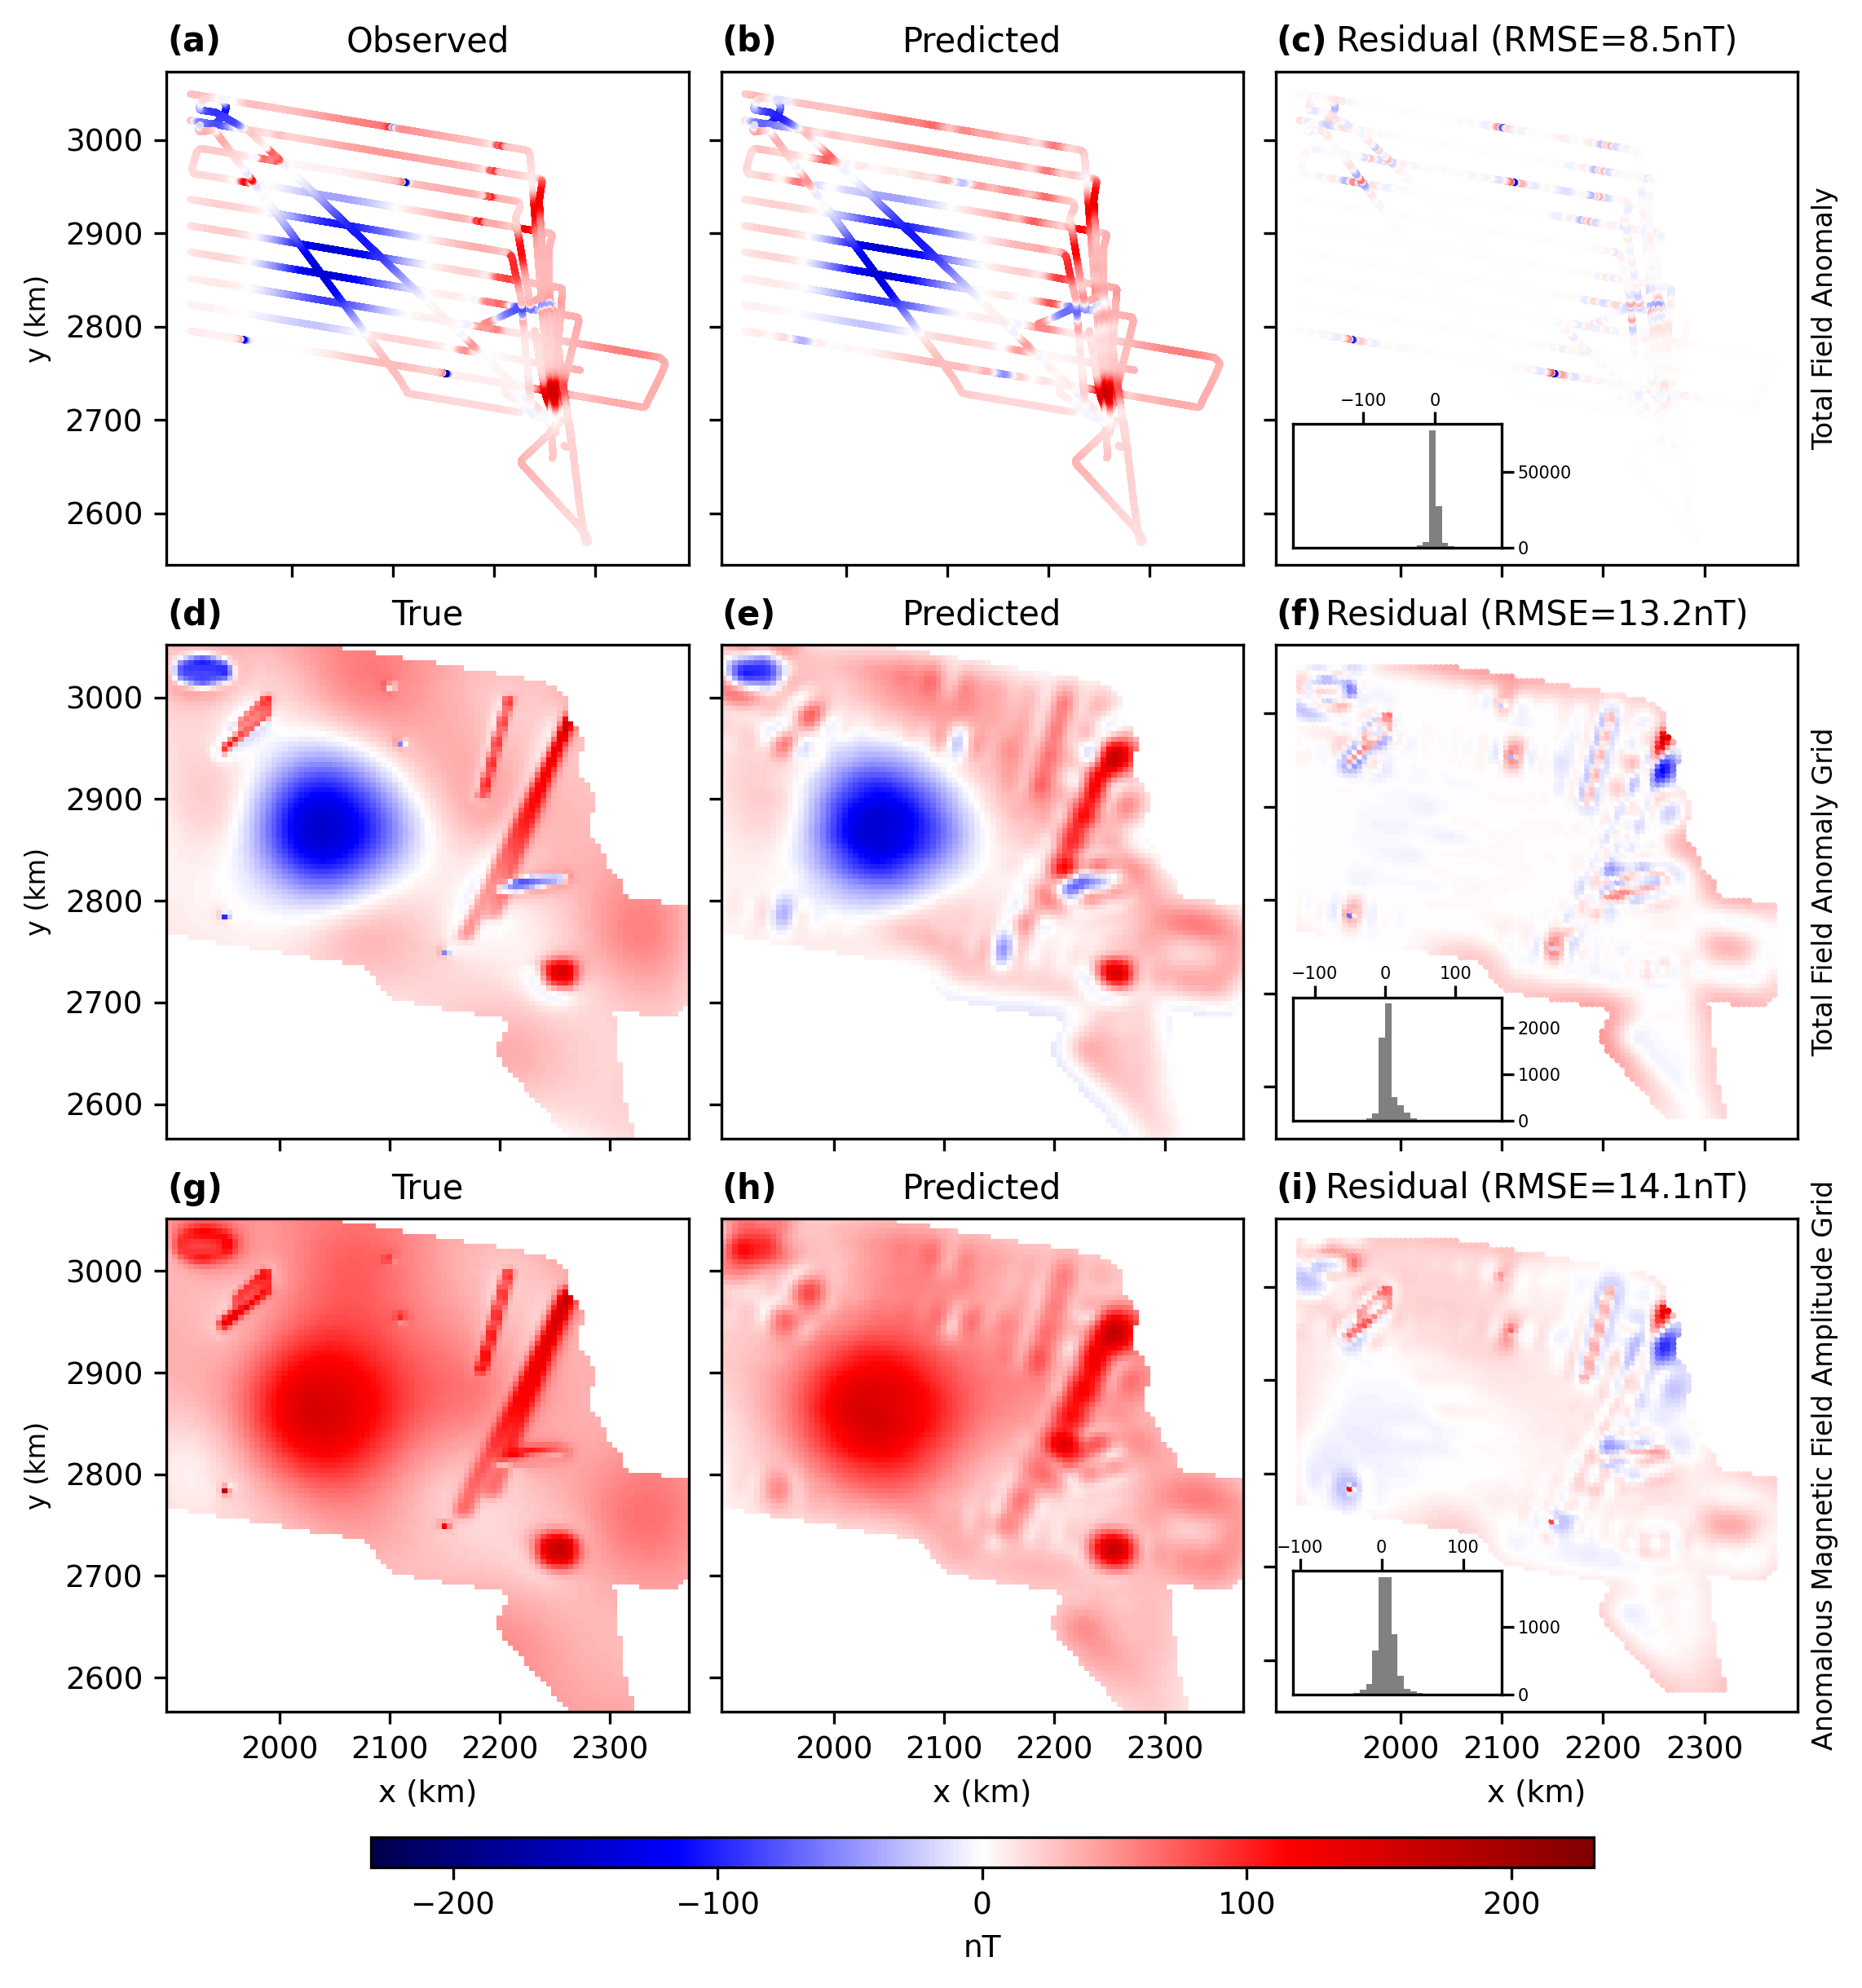

In [38]:
plot_config = {
    "row1": {
        "titles": ['Observed', 'Predicted', f'Residual (RMSE={np.round(rmse_tfa_1layer,1)}nT)'],
        "labels": ['(a)', '(b)', '(c)'],
        "data": [icegrav_synthetic.tfa, tfa_predicted_1layer, error_tfa_1layer],
        "coords": [coordinates_km] * 3,
        "plot_types": ['scatter', 'scatter', 'scatter'],
        "scales": [scale_tfa_synthetic] * 3,
        "ylabels": ['y (km)', '', 'Total Field Anomaly'],
        "hist_insets": [False, False, True],
        "hist_data": [None, None, error_tfa_1layer.ravel()],
    },
    "row2":{
        "titles": ['True', 'Predicted', f'Residual (RMSE={np.round(rmse_tfa_grid_1layer,1)}nT)'],
        "labels": ['(d)', '(e)', '(f)'],
        "data": [true_tfa, predicted_tfa_grid_1layer, error_tfa_grid_1layer],
        "coords": [grid_coordinates_km] * 3,
        "plot_types": ['pcolormesh', 'pcolormesh', 'scatter'],
        "scales": [scale_tfa_synthetic] * 3,
        "ylabels": ['y (km)', '', 'Total Field Anomaly Grid'],
        "hist_insets": [False, False, True],
        "hist_data": [None, None, error_tfa_grid_1layer.ravel()],
    },
    "row3":{
        "titles": ['True', 'Predicted', f'Residual (RMSE={np.round(rmse_bnorm_grid_1layer,1)}nT)'],
        "labels": ['(g)', '(h)', '(i)'],
        "data": [true_bnorm, predicted_bnorm_grid_1layer, error_bnorm_grid_1layer],
        "plot_types": ['pcolormesh', 'pcolormesh', 'scatter'],
        "coords": [grid_coordinates_km] * 3,
        "scales": [scale_tfa_synthetic] * 3,
        "ylabels": ['y (km)', '', 'Anomalous Magnetic Field Amplitude Grid'],
        "hist_insets": [False, False, True],
        "hist_data": [None, None, error_bnorm_grid_1layer.ravel()],
    },
}

fig, ax = plt.subplots(3, 3, figsize=(7.5, 8), constrained_layout=True)

last_plot = None

for row_idx, (row_key, row) in enumerate(plot_config.items()):
    for col_idx in range(3):
        ptype = row["plot_types"][col_idx]
        data = row["data"][col_idx]
        coords = row["coords"][col_idx]
        scale = row["scales"][col_idx]
        title = row["titles"][col_idx]
        ylabel = row["ylabels"][col_idx]
        label = row["labels"][col_idx]
        hist_inset = row["hist_insets"][col_idx]
        hist_data = row["hist_data"][col_idx]
        
        ax_cur = ax[row_idx, col_idx]
        
        if ptype == "scatter":
            plot = ax_cur.scatter(
                *coords[:2],
                c=data,
                cmap="seismic",
                s=1,
                vmin=-scale,
                vmax=scale,
            )
        elif ptype == "pcolormesh":
            plot = ax_cur.pcolormesh(
                *coords[:2],
                data,
                cmap="seismic",
                vmin=-scale,
                vmax=scale,
            )
        else:
            raise ValueError(f"Unknown plot type: {ptype}")
        
        last_plot = plot

        ax_cur.set_title(title, fontsize=10)
        
        if ylabel:
            ax_cur.set_ylabel(ylabel, fontsize=8)
            if col_idx == 0:
                ax_cur.tick_params(axis='y', labelleft=True, labelright=False, labelsize=9)
            elif col_idx == 2:
                ax_cur.yaxis.set_label_position("right")
                ax_cur.tick_params(axis='y', labelleft=False, labelright=False)
            else:
                ax_cur.set_ylabel('')
                ax_cur.tick_params(axis='y', labelleft=False, labelright=False)
        else:
            ax_cur.set_ylabel('')
            ax_cur.tick_params(axis='y', labelleft=False, labelright=False)
            
        if row_idx == 2:
            ax_cur.set_xlabel("x (km)", fontsize=9)

        ax_cur.text(0.001, 1.095, label, transform=ax_cur.transAxes, weight="bold", fontsize=10, va="top")

        if hist_inset and hist_data is not None:
            inset_ax = inset_axes(
                ax_cur,
                width="40%",
                height="25%",
                loc="lower left",
                bbox_to_anchor=(0.001, 0.001, 1, 1),
                bbox_transform=ax_cur.transAxes,
            )
            inset_ax.hist(hist_data, bins=30, color="gray")
            inset_ax.tick_params(labelsize=5, pad=1)
            inset_ax.xaxis.set_ticks_position('top')
            inset_ax.xaxis.set_label_position('top')
            inset_ax.yaxis.set_ticks_position('right')
            inset_ax.yaxis.set_label_position('right')
            # mean_val = np.nanmean(hist_data)
            # std_val = np.nanstd(hist_data)
            # inset_ax.text(
            #     0.05, 0.95,
            #     f"Mean = {mean_val:.1f} nT\nSTD = {std_val:.1f} nT",
            #     transform=inset_ax.transAxes,
            #     fontsize=4,
            #     verticalalignment='top',
            #     bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1),
            # )

xticks = [2000, 2100, 2200, 2300]
for row_idx in range(3):
    for col_idx in range(3):
        ax[row_idx, col_idx].set_xticks(xticks)
        ax[row_idx, col_idx].set_xticklabels([str(int(t)) for t in xticks], fontsize=9)
        ax[row_idx, col_idx].xaxis.set_major_locator(FixedLocator(xticks))

for row_idx in range(2):
    for col_idx in range(3):
        ax[row_idx, col_idx].set_xticklabels([])

cbar = fig.colorbar(
    last_plot,
    ax=ax,
    orientation='horizontal',
    label='nT',
    pad=0.015,
    shrink=0.75,
    aspect=40
)
cbar.ax.tick_params(labelsize=9)
cbar.ax.xaxis.label.set_size(9)

single_layer_figure = Path("..") / "paper" / "figures" / "single_layer_synthetic.png"
fig.savefig(single_layer_figure, dpi=300, bbox_inches="tight")
plt.close()
Image(single_layer_figure)

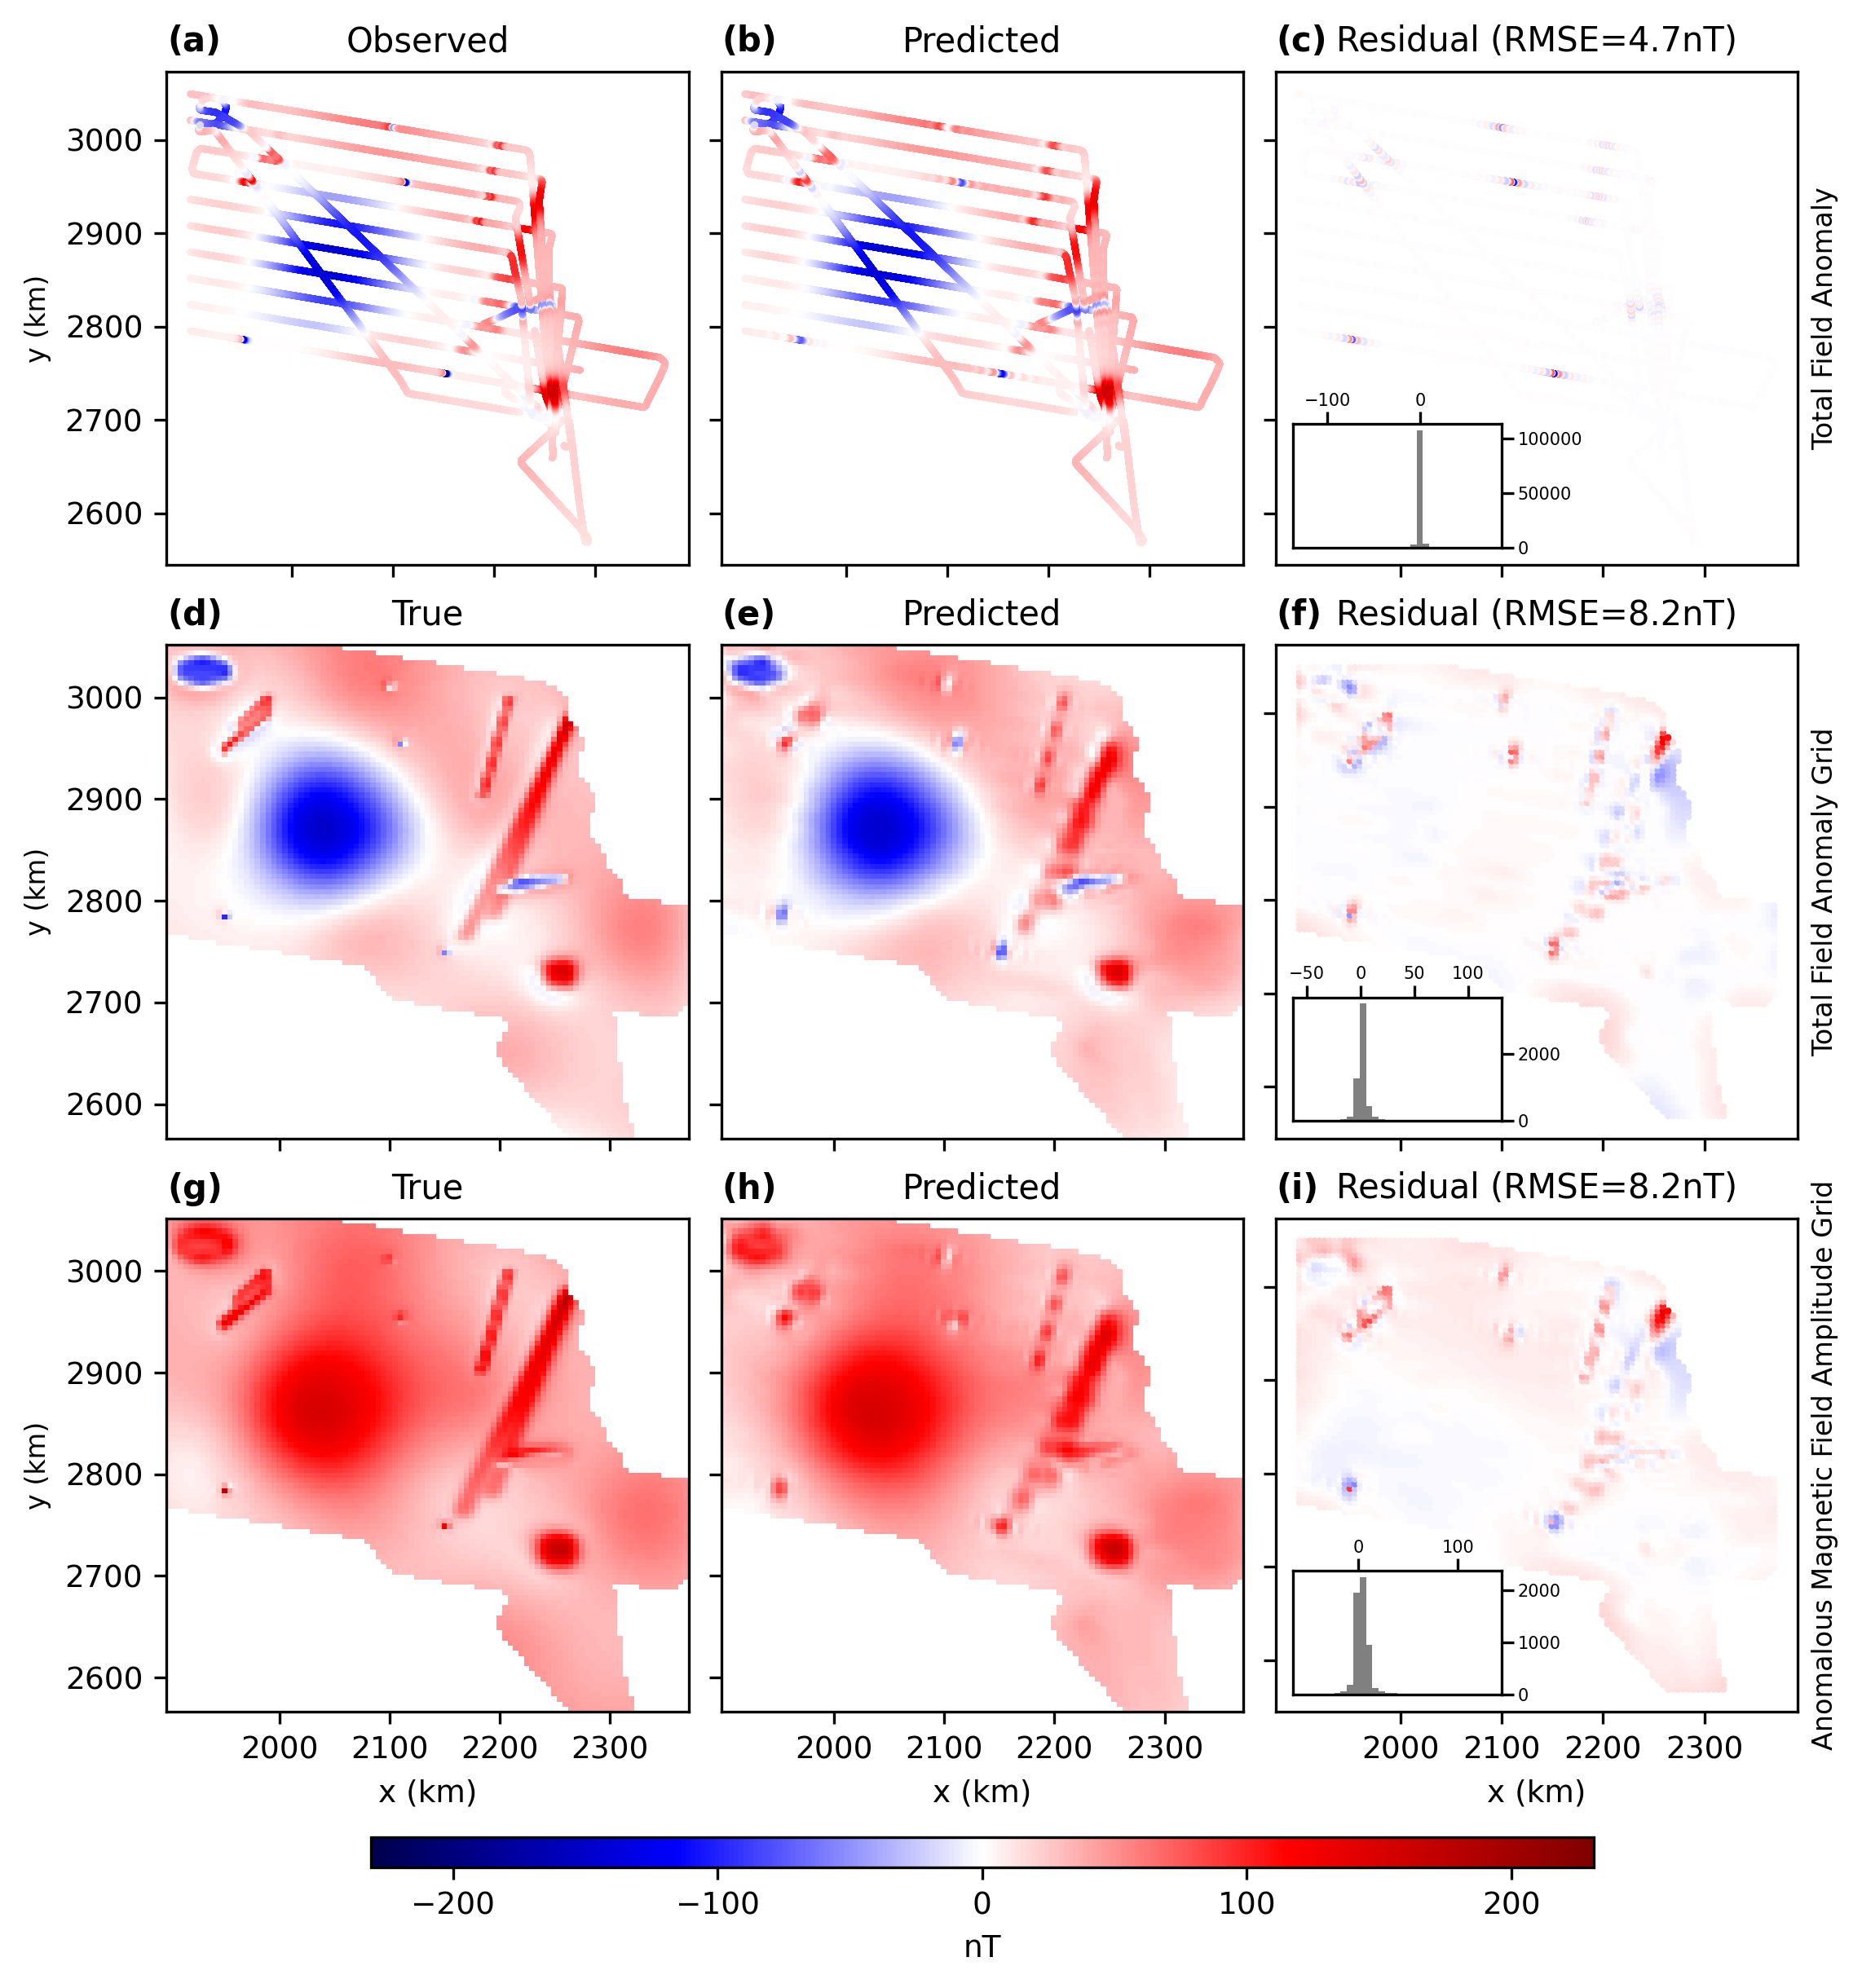

In [39]:
plot_config = {
    "row1": {
        "titles": ['Observed', 'Predicted', f'Residual (RMSE={np.round(rmse_tfa,1)}nT)'],
        "labels": ['(a)', '(b)', '(c)'],
        "data": [icegrav_synthetic.tfa, predicted_tfa, error_tfa],
        "coords": [coordinates_km] * 3,
        "plot_types": ['scatter', 'scatter', 'scatter'],
        "scales": [scale_tfa_synthetic] * 3,
        "ylabels": ['y (km)', '', 'Total Field Anomaly'],
        "hist_insets": [False, False, True],
        "hist_data": [None, None, error_tfa.ravel()],
    },
    "row2":{
        "titles": ['True', 'Predicted', f'Residual (RMSE={np.round(rmse_tfa_grid,1)}nT)'],
        "labels": ['(d)', '(e)', '(f)'],
        "data": [true_tfa, predicted_tfa_grid, error_tfa_grid],
        "coords": [grid_coordinates_km] * 3,
        "plot_types": ['pcolormesh', 'pcolormesh', 'scatter'],
        "scales": [scale_tfa_synthetic] * 3,
        "ylabels": ['y (km)', '', 'Total Field Anomaly Grid'],
        "hist_insets": [False, False, True],
        "hist_data": [None, None, error_tfa_grid.ravel()],
    },
    "row3":{
        "titles": ['True', 'Predicted', f'Residual (RMSE={np.round(rmse_bnorm_grid,1)}nT)'],
        "labels": ['(g)', '(h)', '(i)'],
        "data": [true_bnorm, predicted_bnorm_grid, error_bnorm_grid],
        "plot_types": ['pcolormesh', 'pcolormesh', 'scatter'],
        "coords": [grid_coordinates_km] * 3,
        "scales": [scale_tfa_synthetic] * 3,
        "ylabels": ['y (km)', '', 'Anomalous Magnetic Field Amplitude Grid'],
        "hist_insets": [False, False, True],
        "hist_data": [None, None, error_bnorm_grid.ravel()],
    },
}

fig, ax = plt.subplots(3, 3, figsize=(7.5, 8), constrained_layout=True)

last_plot = None

for row_idx, (row_key, row) in enumerate(plot_config.items()):
    for col_idx in range(3):
        ptype = row["plot_types"][col_idx]
        data = row["data"][col_idx]
        coords = row["coords"][col_idx]
        scale = row["scales"][col_idx]
        title = row["titles"][col_idx]
        ylabel = row["ylabels"][col_idx]
        label = row["labels"][col_idx]
        hist_inset = row["hist_insets"][col_idx]
        hist_data = row["hist_data"][col_idx]
        
        ax_cur = ax[row_idx, col_idx]
        
        if ptype == "scatter":
            plot = ax_cur.scatter(
                *coords[:2],
                c=data,
                cmap="seismic",
                s=1,
                vmin=-scale,
                vmax=scale,
            )
        elif ptype == "pcolormesh":
            plot = ax_cur.pcolormesh(
                *coords[:2],
                data,
                cmap="seismic",
                vmin=-scale,
                vmax=scale,
            )
        else:
            raise ValueError(f"Unknown plot type: {ptype}")
        
        last_plot = plot

        ax_cur.set_title(title, fontsize=10)
        
        if ylabel:
            ax_cur.set_ylabel(ylabel, fontsize=8)
            if col_idx == 0:
                ax_cur.tick_params(axis='y', labelleft=True, labelright=False, labelsize=9)
            elif col_idx == 2:
                ax_cur.yaxis.set_label_position("right")
                ax_cur.tick_params(axis='y', labelleft=False, labelright=False)
            else:
                ax_cur.set_ylabel('')
                ax_cur.tick_params(axis='y', labelleft=False, labelright=False)
        else:
            ax_cur.set_ylabel('')
            ax_cur.tick_params(axis='y', labelleft=False, labelright=False)
            
        if row_idx == 2:
            ax_cur.set_xlabel("x (km)", fontsize=9)

        ax_cur.text(0.001, 1.095, label, transform=ax_cur.transAxes, weight="bold", fontsize=10, va="top")

        if hist_inset and hist_data is not None:
            inset_ax = inset_axes(
                ax_cur,
                width="40%",
                height="25%",
                loc="lower left",
                bbox_to_anchor=(0.001, 0.001, 1, 1),
                bbox_transform=ax_cur.transAxes,
            )
            inset_ax.hist(hist_data, bins=30, color="gray")
            inset_ax.tick_params(labelsize=5, pad=1)
            inset_ax.xaxis.set_ticks_position('top')
            inset_ax.xaxis.set_label_position('top')
            inset_ax.yaxis.set_ticks_position('right')
            inset_ax.yaxis.set_label_position('right')

xticks = [2000, 2100, 2200, 2300]
for row_idx in range(3):
    for col_idx in range(3):
        ax[row_idx, col_idx].set_xticks(xticks)
        ax[row_idx, col_idx].set_xticklabels([str(int(t)) for t in xticks], fontsize=9)
        ax[row_idx, col_idx].xaxis.set_major_locator(FixedLocator(xticks))

for row_idx in range(2):
    for col_idx in range(3):
        ax[row_idx, col_idx].set_xticklabels([])

cbar = fig.colorbar(
    last_plot,
    ax=ax,
    orientation='horizontal',
    label='nT',
    pad=0.015,
    shrink=0.75,
    aspect=40
)
cbar.ax.tick_params(labelsize=9)
cbar.ax.xaxis.label.set_size(9)

dual_layer_figure = Path("..") / "paper" / "figures" / "dual_layer_synthetic.png"
fig.savefig(dual_layer_figure, dpi=300, bbox_inches="tight")
plt.close()
Image(dual_layer_figure)